# Billiard : Limacon of Pascal

In [1]:
WaLL[{a_, \[Epsilon]_}, t_] := {a*(1 + \[Epsilon]*Cos[t]) Cos[t], a*(1 + \[Epsilon]*Cos[t]) Sin[t]};
BB[a_, \[Epsilon]_] := 
    ParametricPlot[
        WaLL[{a, \[Epsilon]}, t], 
        {t, 0, 2 Pi},
        Axes -> False, 
        AspectRatio -> Automatic, 
        PlotStyle -> Black
    ];

{Labeled[-Graphics-, FormBox[RowBox[{"ϵ", "", "0.`"}], TraditionalForm], 
 
>    {ImageSize -> 100}], Labeled[-Graphics-, 
 
>    FormBox[RowBox[{"ϵ", "", "0.2`"}], TraditionalForm], {ImageSize -> 100}], 
 
>   Labeled[-Graphics-, FormBox[RowBox[{"ϵ", "", "0.4`"}], TraditionalForm], 
 
>    {ImageSize -> 100}], Labeled[-Graphics-, 
 
>    FormBox[RowBox[{"ϵ", "", "0.6000000000000001`"}], TraditionalForm], 
 
>    {ImageSize -> 100}], Labeled[-Graphics-, 
 
>    FormBox[RowBox[{"ϵ", "", "0.8`"}], TraditionalForm], {ImageSize -> 100}], 
 
>   Labeled[-Graphics-, FormBox[RowBox[{"ϵ", "", "1.`"}], TraditionalForm], 
 
>    {ImageSize -> 100}]}
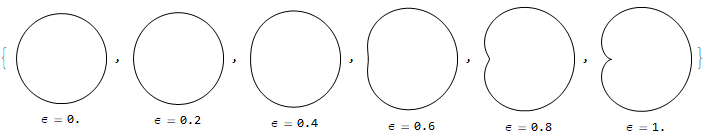

In [5]:
Show[Labeled[BB[1, #], TraditionalForm[\[Epsilon] == #]], ImageSize -> 100] & /@ Range[0, 1, 0.2]

# Trajectory

In [6]:
PascalCurve[{a_, \[Epsilon]_}, x_, y_] := (x^2 + y^2 - a*\[Epsilon]*x)^2 - a^2 (x^2 + y^2);

TrajPascal[{a_, \[Epsilon]_}, {x0_, y0_}, {vx0_, vy0_}, tmax_] := 
    Module[
        {NV, nvec, refV},
        NV = Grad[PascalCurve[{a, \[Epsilon]}, xB, yB], {xB, yB}]/Norm[Grad[PascalCurve[{a, \[Epsilon]}, xB, yB], {xB, yB}]];
        NDSolve[
            {
            x'[t] == vx[t], 
            y'[t] == vy[t],
            x[0] == x0,
            y[0] == y0,
            vx[0] == vx0,
            vy[0] == vy0,
            WhenEvent[
                PascalCurve[{a, \[Epsilon]}, x[t], y[t]] == 0,
                {nvec = (NV /. xB -> x[t] /. yB -> y[t]);
                refV = {vx[t], vy[t]} - 2*({vx[t], vy[t]}.nvec) nvec;
                {vx[t], vy[t]} -> refV}
            ]
            }, {x, y}, {t, 0, tmax},
            (* Be careful of step size, or WhenEvent will miss the point *)
            StartingStepSize -> 1/100,
            Method -> {"FixedStep", Method -> "ExplicitEuler"},
            DiscreteVariables -> {vx, vy}
        ]
    ]

In [8]:
sols = TrajPascal[{1, #}, {0.2, 0.4}, {0.5, 0.2}, 100] & /@ Range[0, 1, 0.2];

In [26]:
TrajView[sol_, \[Epsilon]_, tmax_, opts___] := 
    Module[
        {Trajfigs},
        Trajfigs = {
            ParametricPlot[
                {x[t], y[t]} /. #1, {t, 0, tmax},
                Frame -> False, 
                AspectRatio -> 1, 
                PlotStyle -> {Red, Thin},
                opts
            ], BB[1, #2]
        } & @@@ Transpose[{sol, \[Epsilon]}];
        GraphicsRow[Show[#, PlotRange -> All, ImageSize -> Small] & /@ Trajfigs]
    ]

-Graphics-
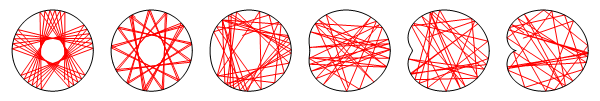

In [28]:
TrajView[sols, Range[0, 1, 0.2], 100, Axes -> False]

# Poincare Section

In [29]:
Pascal[a_, \[Epsilon]_] := ImplicitRegion[(x^2 + y^2 - a*\[Epsilon]*x)^2 - a^2 (x^2 + y^2) <= 0, {x, y}];

MakeInitData[a_, \[Epsilon]_, samplenum_] := 
    Module[
        {xypts, vxvypts},
        SeedRandom["Pascal"];
        xypts = RandomPoint[Pascal[a, \[Epsilon]], samplenum];
        vxvypts = RandomPoint[Circle[], samplenum];
        Return[{xypts, vxvypts}]
    ]

In [31]:
PoincareBilliard[{a_, \[Epsilon]_}, {x0_, y0_, vx0_, vy0_}, tmax_] := 
    Module[
        {refV, NV, nvec, c\[Alpha], p},
        NV = Grad[PascalCurve[{a, \[Epsilon]}, xB, yB], {xB, yB}]/Norm[Grad[PascalCurve[{a, \[Epsilon]}, xB, yB], {xB, yB}]];
        If[# == {}, {}, First[#]] &@ Last[Reap[
            NDSolve[
                {
                x'[t] == vx[t],
                y'[t] == vy[t],
                x[0] == x0,
                y[0] == y0,
                vx[0] == vx0,
                vy[0] == vy0,
                WhenEvent[
                    PascalCurve[{a, \[Epsilon]}, x[t], y[t]] == 0,
                    {nvec = (NV /. xB -> x[t] /. yB -> y[t]);
                    refV = {vx[t], vy[t]} - 2*({vx[t], vy[t]}.nvec) nvec;
                    c\[Alpha] = -refV.nvec/Norm[refV];
                    p = If[
                        ({refV[[1]], refV[[2]], 0}\[Cross]{-nvec[[1]], -nvec[[2]], 0})[[3]] >= 0,
                        Sqrt[1 - c\[Alpha]^2], 
                        -Sqrt[1 - c\[Alpha]^2]
                        ];
                    {vx[t], vy[t]} -> refV, 
                    Sow[{x[t], y[t], p}]}
                ]
                }, {}, {t, 0, tmax},
                (* Be careful of step size, or WhenEvent will miss the point *)
                StartingStepSize -> 1/1000,
                Method -> {"FixedStep", Method -> "ExplicitEuler"},
                DiscreteVariables -> {vx, vy}
            ]
        ]]
    ]

In [32]:
myArcTan[x_, y_] := 
    Piecewise[
        {
        {ArcTan[y/x], x > 0 && y > 0}, 
        {Pi/2, x == 0 && y > 0}, 
        {ArcTan[y/x] + Pi, x < 0 && y > 0}, 
        {Pi, x < 0 && y == 0}, 
        {ArcTan[y/x] + Pi, x < 0 && y < 0}, 
        {3 Pi/2, x == 0 && y < 0}, 
        {2 Pi + ArcTan[y/x], x > 0 && y < 0}
        }
    ];


NArcs[{a_, \[Epsilon]_}, xx_, yy_] := 
    Module[
        {integrad, arctot, phi},
        phi = myArcTan[xx, yy];
        integrad = Norm[D[WaLL[{a, \[Epsilon]}, t], t]];
        arctot = NIntegrate[integrad, {t, 0, 2 Pi}];
        NIntegrate[integrad, {t, 0, phi}]/arctot
    ];

In [41]:
$ConfiguredKernels

{6 local kernels}

In [45]:
DataPoincare[{a_, \[Epsilon]_}, tmax_, plotnum_] := 
    Module[
        {xyinit, vvinit, data},
        {xyinit, vvinit} = MakeInitData[a, \[Epsilon], plotnum];
        SetSharedVariable[SectionptsSet];
        SectionptsSet = 
            Parallelize[
                PoincareBilliard[{a, \[Epsilon]}, #, tmax] & /@ (Flatten[#] & /@ Transpose[{xyinit, vvinit}])
            ];
        Parallelize[
            Table[{NArcs[{a, \[Epsilon]}, #[[i, 1]], #[[i, 2]]], #[[i,3]]}, {i, Length[#]}] & /@ SectionptsSet
        ]
    ];

PlotPoincare[{a_, \[Epsilon]ps_}, plotdata_] := 
    Module[
        {},
        Labeled[
            Show[
                ListPlot[
                    #1,
                    PlotStyle -> {PointSize[.004],
                    Darker[Hue[N[#2/Length[plotdata]]], 0.1]},
                    PlotRange -> {{0, 1}, {-1, 1}}, 
                    Frame -> True, 
                    Axes -> False,
                    PlotLabel -> TraditionalForm[\[Epsilon] == \[Epsilon]ps]
                ] & @@@ Transpose[{plotdata, Range[1, Length[plotdata]]}],
            PlotRange -> {{0, 1}, {-1, 1}}
            ], 
            {s, p}, 
            {Bottom, Left}
        ]
    ];

In [47]:
AbsoluteTiming[SectionDATA = DataPoincare[{1, 0}, 800, 60];]

{172.454, Null}

Labeled[-Graphics-, {s, p}, {Bottom, Left}]
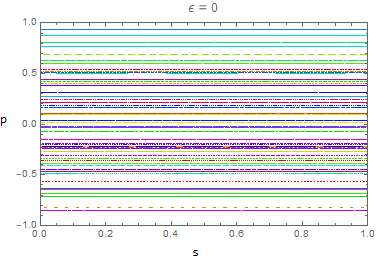

In [48]:
PlotPoincare[{1, 0}, SectionDATA]

In [58]:
CloseKernels[];

In [52]:
AbsoluteTiming[SectionDATA = DataPoincare[{1, 0.5}, 300, 48];]

ParallelCombine::nopar: No parallel kernels available; proceeding with sequential evaluation.

ParallelCombine::nopar: No parallel kernels available; proceeding with sequential evaluation.

{581.659, Null}

Labeled[-Graphics-, {s, p}, {Bottom, Left}]
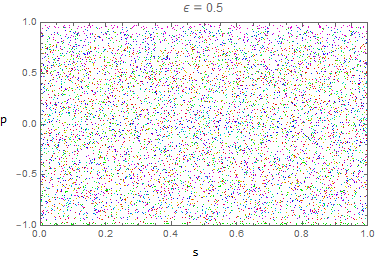

In [54]:
PlotPoincare[{1, 0.5}, SectionDATA]

{KernelObject[19, local], KernelObject[20, local], KernelObject[21, local], 
 
>   KernelObject[22, local], KernelObject[23, local], KernelObject[24, local]}
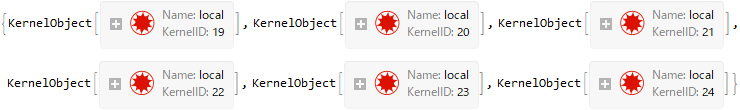

In [56]:
LaunchKernels[]

In [57]:
$KernelCount

6

# Quantum Billiards

In [1]:
QuantumBilliards[\[CapitalOmega]_, levnumber_] := 
    NDEigensystem[
        {-Laplacian[u[x, y], {x, y}], DirichletCondition[u[x, y] == 0, True]},
        u[x, y], 
        {x, y} \[Element] \[CapitalOmega], 
        levnumber,
        Method -> {
            "SpatialDiscretization" -> {"FiniteElement", {"MeshOptions" -> {"MaxCellMeasure" -> 0.0001}}},
            "Eigensystem" -> {"Arnoldi", "MaxIterations" -> Infinity}
        }
    ];

In [2]:
QuantumBilliardsEigenval[\[CapitalOmega]_, levnumber_] := 
    NDEigenvalues[
        {-Laplacian[u[x, y], {x, y}], DirichletCondition[u[x, y] == 0, True]},
        u[x, y], 
        {x, y} \[Element] \[CapitalOmega], 
        levnumber, 
        Method -> {
            "SpatialDiscretization" -> {"FiniteElement", {"MeshOptions" -> {"MaxCellMeasure" -> 0.0001}}}, 
            "Eigensystem" -> {"Arnoldi", "MaxIterations" -> Infinity}
        }
    ];

In [3]:
jet[u_?NumericQ] := 
    Blend[{
        {0, RGBColor[0, 0, 9/16]}, 
        {1/9, Blue}, 
        {23/63, Cyan}, 
        {13/21, Yellow}, 
        {47/63, Orange}, 
        {55/63, Red}, 
        {1, RGBColor[1/2, 0, 0]}
    }, u] /; 0 <= u <= 1

In [4]:
(* Making uniform 10^5 data for Plotting Probability density *)
DummyDataGenerator[\[CapitalOmega]_] := 
    Module[
        {mf, pts, col}, 
        mf = RegionMember[\[CapitalOmega]];
        pts = RandomVariate[UniformDistribution[RegionBounds[\[CapitalOmega]]], 10^5];
        mpts = Select[pts, RegionMember[\[CapitalOmega]]];
        col = mf[mpts] /. True -> Red;
        Graphics[{AbsolutePointSize[1], {col, Point /@ mpts}\[Transpose]}, Axes -> True]
    ]

In [6]:
ProbabilityDensityfunctions[Eigvals_, Eigenfunction_, eigennum_, viewnum_] := 
    Module[
        {i},
        ProbDensity = Table[0, {i, 0, viewnum}];
        Table[
            ProbDensity[[i + 1]] = Flatten[List[# , (Eigenfunction[[eigennum + i]][[0]][#[[1]], #[[2]]])^2], 2] & /@ mpts;
            ListDensityPlot[
                ProbDensity[[i + 1]],
                ColorFunction -> (jet[(#)^.4] &),
                AspectRatio -> Automatic,(*PlotLegends\[Rule]Automatic,*)
                PlotRange -> All, 
                PlotLabel -> {eigennum + i, Eigvals[[eigennum + i]]}
            ], {i, 0, viewnum}
        ]
    ]

In [7]:
FullPDFimage[Eigvals_, Eigenfunction_, eigennum_, viewnum_] := 
    Module[
        {i, images},
        ProbDensity = Table[0, {i, 0, viewnum}];
        images = GraphicsGrid[{
            Table[
                ProbDensity[[i + 1]] = Flatten[List[# , (Eigenfunction[[eigennum + i]][[0]][#[[1]], #[[2]]])^2], 2] & /@ mpts ;
                ListDensityPlot[
                    ProbDensity[[i + 1]], 
                    ColorFunction -> (jet[(#)^.4] &), 
                    AspectRatio -> Automatic, 
                    PlotRange -> All, 
                    Frame -> False 
                ], {i, 0, viewnum}
            ]
        }];
        Which[
            Eigvals === Bvals, 
            Table[
                Labeled[
                    ImageAssemble[{
                        {ImageReflect[ImageCrop[images[[1, 2, 1, i, 1]]], Left -> Right],
                         ImageCrop[images[[1, 2, 1, i, 1]]]}, 
                        {ImageReflect[ImageReflect[ImageCrop[images[[1, 2, 1, i, 1]]], Left -> Right], Bottom -> Top],
                         ImageReflect[ImageCrop[images[[1, 2, 1, i, 1]]], Bottom -> Top]}
                    }], {{eigennum + i - 1, Eigvals[[eigennum + i - 1]]}}, {Top}
                ], {i, 1, viewnum + 1}
            ],
            Eigvals === Cvals,
            Table[
                Labeled[
                    ImageAssemble[{
                        {ImageCrop[images[[1, 2, 1, i, 1]]]}, 
                        {ImageReflect[ImageCrop[images[[1, 2, 1, i, 1]]], Bottom -> Top]}
                    }], {{eigennum + i - 1, Eigvals[[eigennum + i - 1]]}}, {Top}
                ], {i, 1, viewnum + 1}
            ],
            Eigvals === Dvals,
            Table[
                Labeled[
                    ImageAssemble[{
                        ImageReflect[ImageCrop[images[[1, 2, 1, i, 1]]], Left -> Right],
                        ImageCrop[images[[1, 2, 1, i, 1]]]
                    }], {{eigennum + i - 1, Eigvals[[eigennum + i - 1]]}}, {Top}
                ], {i, 1, viewnum + 1}
            ]
        ]
    ]

## Bunimovich stadium billiard

-Graphics-
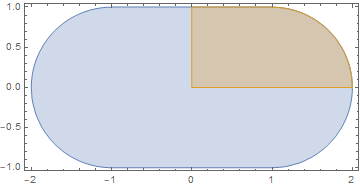

In [19]:
\[CapitalOmega]B = StadiumShape[{{-1, 0}, {1, 0}}, 1];
\[CapitalOmega]Bpart = RegionUnion[Rectangle[{0, 0}, {1, 1}], Disk[{1, 0}, 1, {0, Pi/2}]];

RegionPlot[{\[CapitalOmega]B, \[CapitalOmega]Bpart}, AspectRatio -> Automatic]

-Graphics-
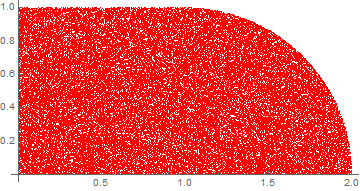

In [22]:
DummyDataGenerator[\[CapitalOmega]Bpart]

In [25]:
{Bvals, Bfuns} = QuantumBilliards[\[CapitalOmega]Bpart, 100];

{Labeled[-Image-, {{80, 639.369}}, {Top}], Labeled[-Image-, {{81, 643.122}}, {Top}], 
 
>   Labeled[-Image-, {{82, 655.036}}, {Top}], Labeled[-Image-, {{83, 660.637}}, {Top}], 
 
>   Labeled[-Image-, {{84, 662.153}}, {Top}], Labeled[-Image-, {{85, 666.195}}, {Top}], 
 
>   Labeled[-Image-, {{86, 676.968}}, {Top}], Labeled[-Image-, {{87, 685.78}}, {Top}], 
 
>   Labeled[-Image-, {{88, 696.355}}, {Top}], Labeled[-Image-, {{89, 701.28}}, {Top}], 
 
>   Labeled[-Image-, {{90, 712.115}}, {Top}]}
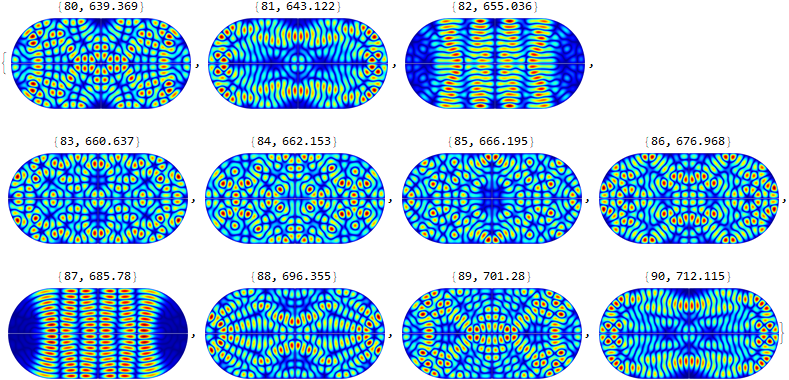

In [26]:
FullPDFimage[Bvals, Bfuns, 80, 10]

## Robnik Billiard

-Graphics-
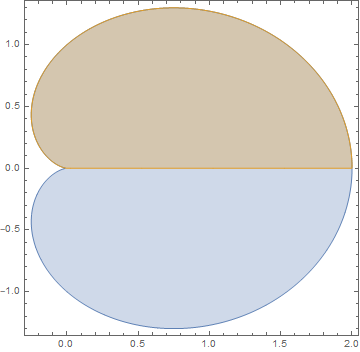

In [8]:
\[CapitalOmega]Card = ImplicitRegion[(x^2 + y^2 - x)^2 <= (x^2 + y^2), {x, y}];
\[CapitalOmega]Cardpart = ImplicitRegion[(x^2 + y^2 - x)^2 <= (x^2 + y^2) && y >= 0, {x, y}];
RegionPlot[{\[CapitalOmega]Card, \[CapitalOmega]Cardpart}]

-Graphics-
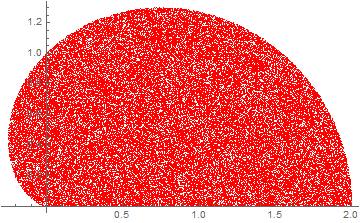

In [11]:
DummyDataGenerator[\[CapitalOmega]Cardpart]

In [14]:
AbsoluteTiming[{Cvals, Cfuns} = QuantumBilliards[\[CapitalOmega]Cardpart, 3000];]  (* CPU : i7-6800K *)

{6653.44, Null}

In [15]:
Length[Cvals]

3000

### Scar mode at 1817 level

{Labeled[-Image-, {{1815, 9953.27}}, {Top}], Labeled[-Image-, {{1816, 9955.99}}, {Top}], 
 
>   Labeled[-Image-, {{1817, 9963.18}}, {Top}], 
 
>   Labeled[-Image-, {{1818, 9964.92}}, {Top}], 
 
>   Labeled[-Image-, {{1819, 9973.45}}, {Top}]}
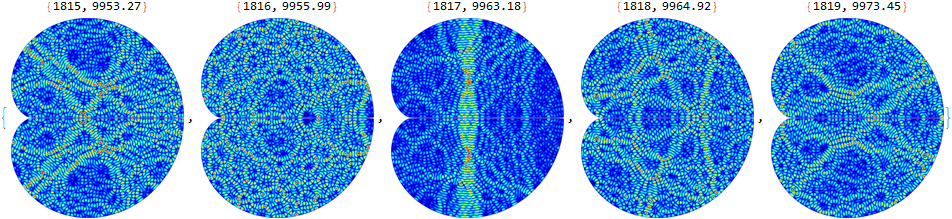

In [16]:
FullPDFimage[Cvals, Cfuns, 1815, 4]

In [17]:
Directory[]

D:\WolframEngine

In [18]:
Export["eigenvals.dat", Cvals]

eigenvals.dat

In [21]:
Export["eigfuncs.m", Cfuns]  (* output file size : near 20GB *)

eigfuncs.m